# System Development

The goal of this notebook is to develop and test the system that will be used in this project

Note: in thi project I use interface in a way that is normally used in langage like C++ or java but I find this way of programming is agood exercice and it's more "SOLID"

In [15]:
import numpy as np
import time
import matplotlib.pyplot as plt
import json
from datetime import datetime

In [2]:
class publisherWrapperInterface:
    
    def connect(self):
        """connect to the broker"""
        pass
    
    def init_message(self, frames_descriptor):
        pass

    def publish(self, topic, frame, callback):
        """publish to others"""
        pass
    
    def flush(self):
        self.producer.flush()
    
    def disconnect():
        """disconnect from the broker"""
        pass

In [3]:
class consumerWrapperInterface:
    
    def connect(self):
        """connect to the broker"""
        pass

    def subscribe(self, topic, callback):
        """subscribe on a topic and listen to upcoming messages"""
        pass
    
    def unsubscribe(self):
        pass
    
    def disconnect():
        """disconnect from the broker"""
        pass

# Data schema object

```

address:{
        camera_id:char,
        monotonic_id:char,
        Preproccess_id:char,
        Preprocessor_id:char,
        
    }

frame = {
    type_of:"frame",
    address:uint,
    num_frame:uint,
    data=char[][]
}

frames_descriptor = {
    type_of:"frames_descriptor",
    datetime:datetime,
    address:uint,
    properties:{
        fps:uint,
        height:uint,
        width:uint,
        channel:uint,
        nb_frames:uint
    }
}
```

# Kafka Publisher Consumer

In [4]:
from confluent_kafka import Producer

class KafkaProducerWrapper(publisherWrapperInterface):
    
    @staticmethod
    def generate_kafkaProducerWrapper(address, port) -> publisherWrapperInterface:
        return KafkaProducerWrapper(address, port)   

    def __init__(self, address, port):
        self.address = address
        self.port = port
        
    def connect(self):
        """connect to the broker"""
        connection_str = self.address + ":" + self.port
        conf = {
        'bootstrap.servers' : connection_str
        }
        print("connecting to Kafka topic...")
        self.producer = Producer(conf)
        
    def init_message(self, frames_descriptor):
        pass

    def publish(self, topic, frame, callback):
        """publish to others"""
        self.producer.produce(topic=topic, value=frame, key=bytes(), on_delivery=callback)
        
    def flush(self):
        self.producer.flush()
        
    def disconnect(self) -> dict:
        """kafka doesn't need to disconnect but to respect the interface the method is implemented"""
        pass

In [5]:
from confluent_kafka import Consumer
import threading

class KafkaConsumerWrapper(consumerWrapperInterface):
    
    @staticmethod
    def generate_KafkaConsumerWrapper(address, port, group_id) -> consumerWrapperInterface:
        return KafkaConsumerWrapper(address, port, group_id)   

    def __init__(self, address, port, group_id):
        self.address = address
        self.port = port
        self.group_id = group_id
        
    def connect(self):
        """connect to the broker"""
        connection_str = self.address + ":" + self.port
        conf = {
        'bootstrap.servers' : connection_str,
        'group.id' : self.group_id,
        'auto.offset.reset': 'earliest'
        }
        print("connecting to Kafka topic...")
        self.consumer = Consumer(conf)

    def listen(self):
        self.consumer.subscribe([self.listener_topic])
        while not self.shutdown_flag:
            msg = self.consumer.poll(0.5)
            if msg is None:
                continue
            if msg.error():
                print("Consumer error: {}".format(msg.error()))
                continue
            self.listener_callback(msg.value())
        self.consumer.close()
    
    def subscribe(self, topic, callback):
        """subscribe on a topic and listen to upcoming messages"""
        self.listener_topic = topic
        self.listener_callback = callback
        self.shutdown_flag = False
        self.listener = threading.Thread(target=self.listen)
        # to ensure the thread will not be terminated at the wrong time
        self.listener.setDaemon(True)
        self.listener.start()
        
    def unsubscribe(self):
        self.shutdown_flag = True
        self.listener.join()
        self.listener = None
    
    def disconnect(self) -> dict:
        """kafka doesn't need to disconnect but to respect the interface the method is implemented"""
        pass

In [10]:
# KAFKA Integration tests
# connect() test /!\ should only work if the docker kafka zookeeper environnement is running

topic = "topicTest"
message = "Hello world!"

def callbackTestPublish(errmsg, msg):
    if errmsg is not None:
        print("Delivery failed for Message: {} : {}".format(msg.key(), errmsg))
        assert(False)
    print('Message: {} successfully produced to Topic: {} Partition: [{}] at offset {}'.format(
        msg.value(), msg.topic(), msg.partition(), msg.offset()))
    assert(topic == msg.topic())
    assert(message == msg.value().decode('utf-8'))
    
def callbackTestSubscribe(msg):
    print('Received message: {}'.format(msg.value().decode('utf-8')))
    assert(message == msg.value().decode('utf-8'))

def publishTest():
    pkfk = KafkaProducerWrapper("localhost", "29092")
    pkfk.connect()
    pkfk.publish(topic,message.encode('utf-8'),callbackTestPublish)
    pkfk.flush()

        
def subscribeTest():
    ckfk = KafkaConsumerWrapper.generate_KafkaConsumerWrapper("localhost", "29092", "grouptest")
    ckfk.connect()
    ckfk.subscribe(topic,callbackTestSubscribe)
    time.sleep(5)
    ckfk.unsubscribe()

            

publishTest()
time.sleep(3)
subscribeTest()

connecting to Kafka topic...
Message: b'Hello world!' successfully produced to Topic: topicTest Partition: [0] at offset 9
connecting to Kafka topic...


%5|1652080444.629|REQTMOUT|rdkafka#consumer-8| [thrd:GroupCoordinator]: GroupCoordinator/1: Timed out LeaveGroupRequest in flight (after 5005ms, timeout #0): possibly held back by preceeding blocking JoinGroupRequest with timeout in 292507ms
%4|1652080444.629|REQTMOUT|rdkafka#consumer-8| [thrd:GroupCoordinator]: GroupCoordinator/1: Timed out 1 in-flight, 0 retry-queued, 0 out-queue, 0 partially-sent requests
%3|1652080444.630|FAIL|rdkafka#consumer-8| [thrd:GroupCoordinator]: GroupCoordinator: 1 request(s) timed out: disconnect (after 10497ms in state UP)


# FrameOverKafka

In [6]:
class VideoOutputKafka:
    
    def __init__(self, callback_analysis, address="localhost", port="29092", groupid="groupbase"):

        self.consumer = KafkaConsumerWrapper(address, port, groupid)
        self.frames_in_transfert = {}   
        self.callback_analysis = callback_analysis
        
    def callbackSub(self, frame):
        try:
            #/!\ should be replace with somthing like avro
            frame = json.loads(frame.decode('utf-8'))

            # If we receive a frames_descriptor object, we must create a new temporary object
            if frame["type_of"] == "frames_descriptor":
                data = np.zeros([frame["frame_properties"]["nb_frames"],
                                 frame["frame_properties"]["height"],
                                 frame["frame_properties"]["width"],
                                 frame["frame_properties"]["nb_channels"]])
                
                frame_object = {'frame_properties': frame['frame_properties'],
                                'frames_data': data}

                self.frames_in_transfert[frame["ID"]] = frame_object
                
            # add the frame data to the temporary object
            elif frame["type_of"] == "frame":
                self.frames_in_transfert[frame["ID"]]["frames_data"][frame["num_frame"]] = frame["data"]

            # when the frame ends
            elif frame["type_of"] == "frames_end":
                self.callback_analysis(self.frames_in_transfert[frame["ID"]])
                self.frames_in_transfert.pop(frame["ID"])
        except:
            print("bad frame")

    
    def start(self, topic_in):
        self.consumer.connect()
        self.consumer.subscribe(topic_in, self.callbackSub)
        
    def stop(self):
        self.consumer.unsubscribe()
    

In [7]:
# VideoOutputKafka test

def callbackTestPublish(errmsg, msg):
    if errmsg is not None:
        print(msg)
        
def test_callback(frame_object):
    print(frame_object)
    
    compare = [[[[1., 1., 1.],
                 [1., 1., 1.],
                 [1., 1., 1.]]],
               [[[1., 1., 1.],
                 [1., 1., 1.],
                 [1., 1., 1.]]],
               [[[1., 1., 1.],
                 [1., 1., 1.],
                 [1., 1., 1.]]]]

    assert(np.array_equal(frame_object["frames_data"], compare))
    

camera_id = "00000001"
monotonic_id = "00000001"
Preproccess_id = "00000001"
Preprocessor_id = "00000001"
ID = monotonic_id + camera_id + Preproccess_id + Preprocessor_id
ID = int(ID, 2)

frame_properties = {
        "fps":30,
        "height":3,
        "width":3,
        "nb_channels":1,
        "nb_frames":3
    }

frames_descriptor = {
            "ID": ID,
            "frame_properties":frame_properties  
        }

frames_descriptor_begin = frames_descriptor.copy()
frames_descriptor_frame = frames_descriptor.copy()
frames_descriptor_end   = frames_descriptor.copy()

frames_descriptor_begin["type_of"] = "frames_descriptor"

frame = [[[1,1,1],
         [1,1,1],
         [1,1,1]]]

frames_descriptor_frame["data"] = frame
frames_descriptor_frame["num_frame"] = 0
frames_descriptor_frame["type_of"] = "frame"

frames_descriptor_end["type_of"] = "frames_end"


topic = "topicTest"
print(frames_descriptor_frame)
frames_descriptor_begin = json.dumps(frames_descriptor_begin).encode('utf-8')
frames_descriptor_frame_ready = json.dumps(frames_descriptor_frame).encode('utf-8')
frames_descriptor_end = json.dumps(frames_descriptor_end).encode('utf-8')

vok = VideoOutputKafka(test_callback, groupid="voktest7")
vok.start(topic)

pkfk = KafkaProducerWrapper("localhost", "29092")
pkfk.connect()
pkfk.publish(topic, frames_descriptor_begin,callbackTestPublish)
time.sleep(1)
pkfk.publish(topic, frames_descriptor_frame_ready,callbackTestPublish)
frames_descriptor_frame["num_frame"] = 1
frames_descriptor_frame_ready = json.dumps(frames_descriptor_frame).encode('utf-8')
time.sleep(1)
pkfk.publish(topic, frames_descriptor_frame_ready, callbackTestPublish)
frames_descriptor_frame["num_frame"] = 2
frames_descriptor_frame_ready = json.dumps(frames_descriptor_frame).encode('utf-8')
time.sleep(1)
pkfk.publish(topic, frames_descriptor_frame_ready, callbackTestPublish)
time.sleep(1)
pkfk.publish(topic, frames_descriptor_end, callbackTestPublish)
time.sleep(1)
pkfk.flush()

time.sleep(3)
vok.stop()

{'ID': 16843009, 'frame_properties': {'fps': 30, 'height': 3, 'width': 3, 'nb_channels': 1, 'nb_frames': 3}, 'data': [[[1, 1, 1], [1, 1, 1], [1, 1, 1]]], 'num_frame': 0, 'type_of': 'frame'}
connecting to Kafka topic...
connecting to Kafka topic...
{'frame_properties': {'fps': 30, 'height': 3, 'width': 3, 'nb_channels': 1, 'nb_frames': 3}, 'frames_data': array([[[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]],


       [[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]],


       [[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]]])}


# Graph Publisher Wrapper

In [8]:
import json
class GraphProducer(publisherWrapperInterface):
    
    @staticmethod
    def generate_GraphProducer() -> consumerWrapperInterface:
        return GraphProducer()   

    def connect(self):
        """nothing to do"""
        pass

    def init_message(self, topic, frames_descriptor):
        self.json_obj = frames_descriptor
        self.name = topic + "/" + str(frames_descriptor["address"]["datetime"]).replace(' ', '_') + ".json"
        self.json_obj["data"] = []

    def publish(self, topic, frame, callback):
        """publish to others"""
        self.json_obj["data"].append(frame)
        callback(frame)
    
    def flush(self):
        
        with open(self.name,'w') as jsonFile:
            json.dump(self.json_obj, jsonFile)
    
    def disconnect():
        """nothing to do"""
        pass

In [16]:
# Unit Test graph publisher 
frames_descriptor = {
    "type_of":"frames_descriptor",
    "address":{
        "camera_id":1,
        "monotonic_id":1,
        "Preproccess_id":1,
        "Preprocessor_id":1,
        "frames_descriptor_id":1,
        "datetime":str(datetime.now())
    },
    "frame_properties":{
        "fps":fps,
        "height":fheight,
        "width":fwidth,
        "channel":3,
        "nb_frames":100
    }
}

topic = "video_test/output"
   
def callbackTestPublish(frame):
    print(frame)
    
def publishTest():
    cvc = GraphProducer.generate_GraphProducer()
    cvc.connect()
    cvc.init_message(topic, frames_descriptor)
    cvc.publish(topic,"Hello" , callbackTestPublish)
    cvc.publish(topic,"World" , callbackTestPublish)
    cvc.publish(topic,"!!!" , callbackTestPublish)
    cvc.flush()

publishTest()

Hello
World
!!!


# FileSystem/OpenCV Publisher Consumer Wrapper

In [17]:
import cv2

In [18]:
class CVProducer(publisherWrapperInterface):
    
    @staticmethod
    def generate_CVProducer(fourcc) -> consumerWrapperInterface:
        return CVProducer(fourcc)   

    def __init__(self, fourcc):
        self.fourcc = fourcc

    def connect(self):
        """nothing to do"""
        pass

    def init_message(self, topic, frames_descriptor):
        
        name = topic + "/" + str(frames_descriptor["address"]["datetime"]).replace(' ', '_') + ".avi"

        self.out = cv2.VideoWriter(name,
                              self.fourcc,
                              frames_descriptor["frame_properties"]["fps"],
                              (frames_descriptor["frame_properties"]["width"], 
                               frames_descriptor["frame_properties"]["height"]),
                              frames_descriptor["frame_properties"]["channel"])

    def publish(self, topic, frame, callback):
        """publish to others"""
        self.out.write(frame)
        callback(frame)
    
    def flush(self):
        self.out.release()
    
    def disconnect():
        """nothing to do"""
        pass

In [157]:
class CVConsumer(consumerWrapperInterface):
    
    @staticmethod
    def generate_CVConsumer() -> consumerWrapperInterface:
        return CVConsumer() 
    
    def connect(self):
        """connect to the broker"""
        pass

    def subscribe(self, topic, callback):
        """subscribe on a topic and listen to upcoming messages"""
        self.listener_topic = topic
        self.listener_callback = callback
        self.shutdown_flag = False
        self.listener = threading.Thread(target=self.listen)
        # to ensure the thread will not be terminated at the wrong time
        self.listener.setDaemon(True)
        self.listener.start()
        
    def listen(self):
        try:
            self.video_input = cv2.VideoCapture(self.listener_topic)
            while not self.shutdown_flag:
                ret, frame = self.video_input.read()

                self.listener_callback(ret, frame)
                if frame is None:
                    # if the video has reach the end
                    self.shutdown_flag = True

            self.video_input.release()
        except:
            print("shithahaha")
            self.shutdown_flag = True 
            self.video_input.release()
    
    def unsubscribe(self):
        self.shutdown_flag = True
        self.listener.join()
        self.listener = None
        
    # this method is used when listening on file /!| no need to unsubscribe
    def syncSubscribe(self, topic, callback):
        """subscribe on a topic and listen to upcoming messages"""

        self.listener_topic = topic
        self.listener_callback = callback
        self.video_input = cv2.VideoCapture(self.listener_topic)
        self.video_end = False

        while self.video_input.isOpened() and not self.video_end:
            ret, frame = self.video_input.read()
            if frame is None:
                # if the video has reach the end
                self.video_end = True
                continue
            self.listener_callback(ret, frame)
        self.video_input.release()    
    
    def disconnect(self):
        """disconnect from the broker"""
        pass

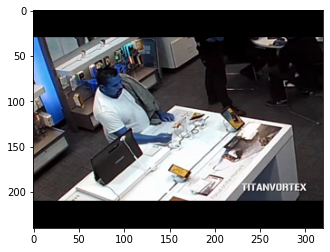

In [116]:
# CV Integration tests


topic = 'video_test/input/Shoplifting054_x264.mp4'
vc = cv2.VideoCapture(topic)
# Read first frame
ret, first_frame = vc.read()
fshape = first_frame.shape
fheight = fshape[0]
fwidth = fshape[1]
fps = int(vc.get(cv2.CAP_PROP_FPS))
plt.imshow(first_frame)
vc.release()

frames_descriptor = {
    "type_of":"frames_descriptor",
    "address":{
        "camera_id":1,
        "monotonic_id":1,
        "Preproccess_id":1,
        "Preprocessor_id":1,
        "frames_descriptor_id":1,
        "datetime":datetime.now()
    },
    "frame_properties":{
        "fps":fps,
        "height":fheight,
        "width":fwidth,
        "channel":3,
        "nb_frames":100
    }
}

   
def callbackTestSubscribe(ret, frame):
    if frame is not None:
        assert(ret)
        assert(frame.shape == first_frame.shape)
    
def subscribeTest():
    cvc = CVConsumer.generate_CVConsumer()
    cvc.connect()
    cvc.subscribe(topic,callbackTestSubscribe)
    time.sleep(5)
    cvc.unsubscribe()
    cvc.syncSubscribe(topic,callbackTestSubscribe)
    

subscribeTest()


In [151]:
format(2,"08")
'{0:08b}'.format(2)

'00000010'

# Video Kafka producer

In [155]:
class VideoInputKafka:
    
    def __init__(self,  
                 frame_properties,
                 frame_preprocess,
                 frame_preprocess_for_detector,
                 event_detector,
                 address="localhost", 
                 port="29092", 
                 camera_id=0):

        self.producer = KafkaProducerWrapper(address, port)
        self.consumer = CVConsumer()

        self.frame_properties = frame_properties
        self.frame_preprocess = frame_preprocess
        self.frame_preprocess_for_detector = frame_preprocess_for_detector
        self.event_detector = event_detector
        
        self.old_frame = None
        
        self.camera_id = format(camera_id,"08")
        self.monotonic_id = 0
        self.Preproccess_id  = "00000000"
        self.Preprocessor_id = "00000000"
        
        self.record_counter = 0
        self.num_frame = 0
        
    def consumerCallback(self, ret, frame):
        if not ret:

            return

        if frame is None:
            if self.record_counter > 0:
                #-------------------------------------------------------------------------------------
                #IF THERE IS AN ERROR AND VIDEO IS RICORDING IT INDICATE THAT THE EVENT ENDS
                self.record_counter = 0
                frames_end = {
                    "ID": ID,
                    "frame_properties":self.frame_properties,
                    "type_of": "frames_end",
                    "datetime": str(datetime.now())
                }
                self.producer.publish(self.topic, json.dumps(frames_end).encode('utf-8'), producerCallback)
            return

        #transform frame
        frame = self.frame_preprocess(frame, self.frame_properties)
        frame_event = self.frame_preprocess_for_detector(frame, self.frame_properties)

        if self.old_frame is None:
            self.old_frame = frame_event
            return    

        if self.event_detector(frame_event, self.old_frame) and self.record_counter == 0:

            self.record_counter = self.frame_properties["nb_frames"]

            ID = '{0:08b}'.format(2) + self.camera_id + self.Preproccess_id + self.Preprocessor_id
            ID = int(ID, 2)

            #-------------------------------------------------------------------------------------
            # SEND THE BEGINING OF A NEW EVENT
            frames_descriptor = {
                "ID": ID,
                "frame_properties":self.frame_properties,
                "type_of": "frames_descriptor",
                "datetime": str(datetime.now())
            }
            self.producer.publish(self.topic, json.dumps(frames_descriptor).encode('utf-8'), producerCallback)

            #-------------------------------------------------------------------------------------
            # SEND THE FIRST FRAME
            
            frames_descriptor["type_of"] = "frame"
            frames_descriptor["num_frame"] = self.num_frame
            #frames_descriptor["data"] = frame.tolist()

            self.producer.publish(self.topic, json.dumps(frames_descriptor).encode('utf-8'), producerCallback)
            self.producer.flush()    

        elif self.record_counter > 0:
            self.num_frame += 1
            self.record_counter -= 1
            
            ID = '{0:08b}'.format(2) + self.camera_id + self.Preproccess_id + self.Preprocessor_id
            ID = int(ID, 2)
            
            #-------------------------------------------------------------------------------------
            #SEND THE FOLLOWING FRAME
            
            frames_descriptor = {
                "ID": ID,
                "frame_properties":self.frame_properties,
                "type_of": "frame",
                "datetime": str(datetime.now()),
                "num_frame": self.num_frame
              #  "data": frame.tolist() 
            }
            self.producer.publish(self.topic, json.dumps(frames_descriptor).encode('utf-8'), producerCallback)
            self.producer.flush()
            
            if self.record_counter == 0:
                
                #-------------------------------------------------------------------------------------
                #INDICATE THAT THE EVENT ENDS
                
                frames_end = {
                    "ID": ID,
                    "frame_properties":self.frame_properties,
                    "type_of": "frames_end",
                    "datetime": str(datetime.now())
                }
  
                self.producer.publish(self.topic, json.dumps(frames_end).encode('utf-8'), producerCallback)
                self.producer.flush()
                self.monotonic_id += 1
                self.num_frame = 0
                
        self.old_frame = frame_event
        
    def producerCallback(self, errmsg, frame):
        pass
    
    def start(self, path, topic):
        
        self.topic = topic
        
        self.producer.connect()
        self.consumer.connect()
        
        self.consumer.subscribe(path, self.consumerCallback)
        
    def stop(self):
        print("has stop")
        self.consumer.unsubscribe()
        self.producer.disconnect()
        self.consumer.disconnect()
        
        

connecting to Kafka topic...
has stop


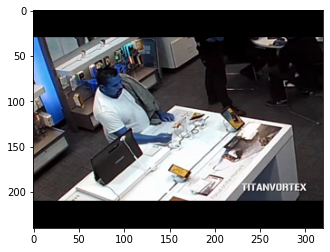

%6|1652135057.840|FAIL|rdkafka#producer-65| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Disconnected (after 16229199ms in state UP)
%6|1652135057.843|FAIL|rdkafka#producer-26| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Disconnected (after 21324269ms in state UP)
%6|1652135057.844|FAIL|rdkafka#producer-25| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Disconnected (after 21352931ms in state UP)
%6|1652135058.444|FAIL|rdkafka#producer-66| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Disconnected while requesting ApiVersion: might be caused by incorrect security.protocol configuration (connecting to a SSL listener?) or broker version is < 0.10 (see api.version.request) (after 11ms in state APIVERSION_QUERY)
%6|1652135058.445|FAIL|rdkafka#producer-2| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Disconnected while requesting ApiVersion: might be caused by incorrect security.protocol configuration (connecting to a SSL listener?) or broker version is 

%6|1652135058.652|FAIL|rdkafka#producer-62| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Disconnected while requesting ApiVersion: might be caused by incorrect security.protocol configuration (connecting to a SSL listener?) or broker version is < 0.10 (see api.version.request) (after 0ms in state APIVERSION_QUERY, 1 identical error(s) suppressed)
%6|1652135058.653|FAIL|rdkafka#producer-27| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Disconnected while requesting ApiVersion: might be caused by incorrect security.protocol configuration (connecting to a SSL listener?) or broker version is < 0.10 (see api.version.request) (after 1ms in state APIVERSION_QUERY, 1 identical error(s) suppressed)
%6|1652135058.656|FAIL|rdkafka#producer-36| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Disconnected while requesting ApiVersion: might be caused by incorrect security.protocol configuration (connecting to a SSL listener?) or broker version is < 0.10 (see api.version.request) 

%3|1652135061.852|FAIL|rdkafka#producer-29| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 33ms in state CONNECT)
%3|1652135062.340|FAIL|rdkafka#producer-65| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT)
%3|1652135062.345|FAIL|rdkafka#producer-23| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT)
%3|1652135062.489|FAIL|rdkafka#producer-69| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT)
%3|1652135062.577|FAIL|rdkafka#producer-2| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT)
%3|1652135062.650|FAIL|rdkafka#producer-27| [thrd:localhost:29092/bootstrap

%3|1652135119.435|FAIL|rdkafka#producer-66| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652135119.441|FAIL|rdkafka#producer-2| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652135119.445|FAIL|rdkafka#producer-24| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652135119.446|FAIL|rdkafka#producer-36| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652135119.451|FAIL|rdkafka#producer-29| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29

%3|1652135179.438|FAIL|rdkafka#producer-66| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652135179.445|FAIL|rdkafka#producer-2| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652135179.447|FAIL|rdkafka#producer-24| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652135179.449|FAIL|rdkafka#producer-36| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652135179.454|FAIL|rdkafka#producer-29| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29

%3|1652135239.441|FAIL|rdkafka#producer-66| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 31 identical error(s) suppressed)
%3|1652135239.447|FAIL|rdkafka#producer-2| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652135239.450|FAIL|rdkafka#producer-24| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652135239.451|FAIL|rdkafka#producer-36| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 31 identical error(s) suppressed)
%3|1652135239.457|FAIL|rdkafka#producer-29| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29

%3|1652135299.444|FAIL|rdkafka#producer-66| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652135299.450|FAIL|rdkafka#producer-2| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 31 identical error(s) suppressed)
%3|1652135299.452|FAIL|rdkafka#producer-24| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 31 identical error(s) suppressed)
%3|1652135299.453|FAIL|rdkafka#producer-36| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652135299.459|FAIL|rdkafka#producer-29| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29

%3|1652135330.503|FAIL|rdkafka#producer-23| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 31 identical error(s) suppressed)
%3|1652135359.447|FAIL|rdkafka#producer-66| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652135359.453|FAIL|rdkafka#producer-2| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652135359.454|FAIL|rdkafka#producer-24| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652135359.455|FAIL|rdkafka#producer-36| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29

%3|1652135390.506|FAIL|rdkafka#producer-23| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652135419.450|FAIL|rdkafka#producer-66| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652135419.455|FAIL|rdkafka#producer-2| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652135419.456|FAIL|rdkafka#producer-24| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652135419.457|FAIL|rdkafka#producer-36| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29

%3|1652135450.508|FAIL|rdkafka#producer-23| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652135479.452|FAIL|rdkafka#producer-66| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652135479.458|FAIL|rdkafka#producer-2| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652135479.458|FAIL|rdkafka#producer-24| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652135479.459|FAIL|rdkafka#producer-36| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29

%3|1652135510.511|FAIL|rdkafka#producer-23| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 31 identical error(s) suppressed)
%3|1652135539.455|FAIL|rdkafka#producer-66| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 31 identical error(s) suppressed)
%3|1652135539.461|FAIL|rdkafka#producer-24| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652135539.461|FAIL|rdkafka#producer-2| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652135539.462|FAIL|rdkafka#producer-36| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29

%3|1652135570.513|FAIL|rdkafka#producer-23| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652135599.459|FAIL|rdkafka#producer-66| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652135599.464|FAIL|rdkafka#producer-36| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652135599.464|FAIL|rdkafka#producer-2| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 31 identical error(s) suppressed)
%3|1652135599.465|FAIL|rdkafka#producer-24| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29

%3|1652135630.516|FAIL|rdkafka#producer-23| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652135659.462|FAIL|rdkafka#producer-66| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652135659.466|FAIL|rdkafka#producer-2| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652135659.466|FAIL|rdkafka#producer-36| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652135659.467|FAIL|rdkafka#producer-24| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29

%3|1652135690.519|FAIL|rdkafka#producer-23| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652135719.464|FAIL|rdkafka#producer-66| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652135719.469|FAIL|rdkafka#producer-36| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652135719.469|FAIL|rdkafka#producer-2| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652135719.469|FAIL|rdkafka#producer-24| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29

%3|1652135750.525|FAIL|rdkafka#producer-23| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 1ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652135779.467|FAIL|rdkafka#producer-66| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652135779.472|FAIL|rdkafka#producer-36| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652135779.472|FAIL|rdkafka#producer-24| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652135779.472|FAIL|rdkafka#producer-2| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29

%3|1652135810.526|FAIL|rdkafka#producer-23| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 31 identical error(s) suppressed)
%3|1652135839.470|FAIL|rdkafka#producer-66| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 31 identical error(s) suppressed)
%3|1652135839.474|FAIL|rdkafka#producer-2| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652135839.474|FAIL|rdkafka#producer-24| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652135839.474|FAIL|rdkafka#producer-36| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29

%3|1652135870.529|FAIL|rdkafka#producer-23| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652135899.474|FAIL|rdkafka#producer-66| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652135899.477|FAIL|rdkafka#producer-24| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 31 identical error(s) suppressed)
%3|1652135899.477|FAIL|rdkafka#producer-2| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 31 identical error(s) suppressed)
%3|1652135899.477|FAIL|rdkafka#producer-36| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29

%3|1652135930.532|FAIL|rdkafka#producer-23| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652135959.477|FAIL|rdkafka#producer-66| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652135959.480|FAIL|rdkafka#producer-24| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652135959.480|FAIL|rdkafka#producer-2| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652135959.480|FAIL|rdkafka#producer-36| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29

%3|1652135990.536|FAIL|rdkafka#producer-23| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652136019.481|FAIL|rdkafka#producer-66| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652136019.482|FAIL|rdkafka#producer-2| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652136019.483|FAIL|rdkafka#producer-24| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652136019.483|FAIL|rdkafka#producer-36| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29

%3|1652136050.539|FAIL|rdkafka#producer-23| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652136079.484|FAIL|rdkafka#producer-66| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652136079.486|FAIL|rdkafka#producer-2| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652136079.486|FAIL|rdkafka#producer-36| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652136079.487|FAIL|rdkafka#producer-24| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29

%3|1652136110.542|FAIL|rdkafka#producer-23| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 31 identical error(s) suppressed)
%3|1652136139.488|FAIL|rdkafka#producer-66| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 31 identical error(s) suppressed)
%3|1652136139.488|FAIL|rdkafka#producer-36| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 31 identical error(s) suppressed)
%3|1652136139.488|FAIL|rdkafka#producer-2| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652136139.489|FAIL|rdkafka#producer-24| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29

%3|1652136170.547|FAIL|rdkafka#producer-23| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652136199.492|FAIL|rdkafka#producer-66| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652136199.492|FAIL|rdkafka#producer-24| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 31 identical error(s) suppressed)
%3|1652136199.492|FAIL|rdkafka#producer-36| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652136199.492|FAIL|rdkafka#producer-2| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29

%3|1652136230.550|FAIL|rdkafka#producer-23| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652136259.495|FAIL|rdkafka#producer-36| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652136259.496|FAIL|rdkafka#producer-66| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652136259.496|FAIL|rdkafka#producer-2| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652136259.496|FAIL|rdkafka#producer-24| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29

%3|1652136290.553|FAIL|rdkafka#producer-23| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652136319.499|FAIL|rdkafka#producer-66| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652136319.499|FAIL|rdkafka#producer-2| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652136319.500|FAIL|rdkafka#producer-24| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652136319.500|FAIL|rdkafka#producer-36| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29

%3|1652136350.556|FAIL|rdkafka#producer-23| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652136379.503|FAIL|rdkafka#producer-36| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652136379.503|FAIL|rdkafka#producer-2| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652136379.503|FAIL|rdkafka#producer-66| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652136379.503|FAIL|rdkafka#producer-24| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29

%3|1652136410.560|FAIL|rdkafka#producer-23| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 31 identical error(s) suppressed)
%3|1652136439.506|FAIL|rdkafka#producer-24| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652136439.506|FAIL|rdkafka#producer-2| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652136439.506|FAIL|rdkafka#producer-36| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 31 identical error(s) suppressed)
%3|1652136439.506|FAIL|rdkafka#producer-66| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29

%3|1652136470.563|FAIL|rdkafka#producer-23| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652136499.510|FAIL|rdkafka#producer-36| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652136499.510|FAIL|rdkafka#producer-2| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 31 identical error(s) suppressed)
%3|1652136499.510|FAIL|rdkafka#producer-66| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652136499.510|FAIL|rdkafka#producer-24| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29

%3|1652136530.566|FAIL|rdkafka#producer-23| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652136559.513|FAIL|rdkafka#producer-36| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652136559.513|FAIL|rdkafka#producer-2| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652136559.513|FAIL|rdkafka#producer-66| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652136559.513|FAIL|rdkafka#producer-24| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29

%3|1652136590.570|FAIL|rdkafka#producer-23| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652136619.516|FAIL|rdkafka#producer-2| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652136619.516|FAIL|rdkafka#producer-66| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652136619.516|FAIL|rdkafka#producer-36| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652136619.517|FAIL|rdkafka#producer-24| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29

%3|1652136650.573|FAIL|rdkafka#producer-23| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652136679.520|FAIL|rdkafka#producer-36| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652136679.520|FAIL|rdkafka#producer-2| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652136679.520|FAIL|rdkafka#producer-24| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652136679.520|FAIL|rdkafka#producer-66| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29

%3|1652136710.576|FAIL|rdkafka#producer-23| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 31 identical error(s) suppressed)
%3|1652136739.523|FAIL|rdkafka#producer-66| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 31 identical error(s) suppressed)
%3|1652136739.523|FAIL|rdkafka#producer-36| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 31 identical error(s) suppressed)
%3|1652136739.524|FAIL|rdkafka#producer-24| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 1ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652136739.525|FAIL|rdkafka#producer-2| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29

%3|1652136770.579|FAIL|rdkafka#producer-23| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652136799.528|FAIL|rdkafka#producer-36| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652136799.528|FAIL|rdkafka#producer-2| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 31 identical error(s) suppressed)
%3|1652136799.529|FAIL|rdkafka#producer-66| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652136799.530|FAIL|rdkafka#producer-24| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29

%3|1652136830.583|FAIL|rdkafka#producer-23| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652136859.531|FAIL|rdkafka#producer-2| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652136859.532|FAIL|rdkafka#producer-66| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652136859.533|FAIL|rdkafka#producer-36| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652136859.533|FAIL|rdkafka#producer-24| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29

%3|1652136890.589|FAIL|rdkafka#producer-23| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652136919.536|FAIL|rdkafka#producer-2| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652136919.536|FAIL|rdkafka#producer-66| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652136919.536|FAIL|rdkafka#producer-36| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)
%3|1652136919.537|FAIL|rdkafka#producer-24| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29

%3|1652136950.590|FAIL|rdkafka#producer-23| [thrd:localhost:29092/bootstrap]: localhost:29092/1: Connect to ipv4#127.0.0.1:29092 failed: Connection refused (after 0ms in state CONNECT, 30 identical error(s) suppressed)


In [159]:
# Test
path = 'video_test/input/Shoplifting054_x264.mp4'
#path = 0
vc = cv2.VideoCapture(path)
# Read first frame
ret, first_frame = vc.read()
fshape = first_frame.shape
fheight = fshape[0]
fwidth = fshape[1]
fps = int(vc.get(cv2.CAP_PROP_FPS))
plt.imshow(first_frame)
vc.release()

frame_properties = {
        "fps":fps,
        "height":150,
        "width":200,
        "nb_channels":3,
        "nb_frames":150
    }

topic = "topicTest"

def prepross(frame,frame_properties):
    return cv2.resize(frame, (frame_properties["height"], frame_properties["width"]))

def prepross2(frame, frame_properties):
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    return cv2.GaussianBlur(gray_frame, (5, 5), 0)

def event_detector(frame, old_frame):
    nb_total = 30000
    
    delta_frame=cv2.absdiff(old_frame, frame)
    threshold_frame = cv2.threshold(delta_frame, 25, 255, cv2.THRESH_BINARY)[1]
    nb_white = np.sum(threshold_frame == 255)
    
    ratio = nb_white / nb_total
    
    return ratio > 0.005
    
def producerCallback(error, frame):
    pass
    
vik = VideoInputKafka(frame_properties, prepross, prepross2, event_detector)

vik.start(path, topic)
time.sleep(20)
vik.stop()

# VideoActionFileSystem

In [59]:
import os

class VideoPreprocessorFromFolder:
    
    def __init__(self, transform, transform_param, frame_properties_input, frame_properties_output):
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        self.producer = CVProducer.generate_CVProducer(fourcc)
        self.consumer = CVConsumer.generate_CVConsumer()
        self.transform = transform
        self.transform_param = transform_param
        self.frame_properties_input  = frame_properties_input
        self.frame_properties_output = frame_properties_output
        self.frames_descriptor = {
            "type_of":"frames_descriptor",
            "address":{
                "camera_id":1,
                "monotonic_id":1,
                "Preproccess_id":1,
                "Preprocessor_id":1,
                "frames_descriptor_id":1,
                "datetime":datetime.now()
            },
            "frame_properties":frame_properties_output  
        }
        
    def produceCallback(self, frame):
        if frame is None:
            #/!\ need to be changed
            print("error")
        
        
    def callbackTransform(self, ret, frame):
        if frame is None:
            return
        if ret:
            frame_t = self.transform(frame, self.transform_param, self.frame_properties_input, self.frame_properties_output)
            self.producer.publish("", frame_t, self.produceCallback)
    
    def start(self, path_in, path_out):
        self.producer.connect()
        self.consumer.connect()
        
        folder = os.listdir(path_in)
        
        for file in folder:
            
            topic_input = os.path.join(path_in, file)
            topic_output = path_out
            
            self.frames_descriptor["address"]["datetime"] = datetime.now()
            
            self.producer.init_message(topic_output, self.frames_descriptor)
            self.consumer.syncSubscribe(topic_input, self.callbackTransform)
            self.producer.flush()

In [74]:
class GraphPreprocessorFromFolder:
    
    def __init__(self, transform, transform_param, frame_properties_input, frame_properties_output):
        self.producer = GraphProducer.generate_GraphProducer()
        self.consumer = CVConsumer.generate_CVConsumer()
        self.transform = transform
        self.transform_param = transform_param
        self.frame_properties_input  = frame_properties_input
        self.frame_properties_output = frame_properties_output
        self.frames_descriptor = {
            "type_of":"graph_descriptor",
            "address":{
                "camera_id":1,
                "monotonic_id":1,
                "Preproccess_id":1,
                "Preprocessor_id":1,
                "frames_descriptor_id":1,
                "datetime":""
            },
            "frame_properties":frame_properties_output  
        }
        
    def produceCallback(self, frame):
        if frame is None:
            #/!\ need to be changed
            print("error")
        
        
    def callbackTransform(self, ret, frame):
        if frame is None:
            return
        if ret:
            frame_t = self.transform(frame, self.transform_param, self.frame_properties_input, self.frame_properties_output)
            self.producer.publish("", frame_t, self.produceCallback)
    
    def start(self, path_in, path_out):
        self.producer.connect()
        self.consumer.connect()
        
        folder = os.listdir(path_in)
        
        for file in folder:
            
            topic_input = os.path.join(path_in, file)
            topic_output = path_out
            
            self.frames_descriptor["address"]["datetime"] = str(datetime.now())

            self.producer.init_message(topic_output, self.frames_descriptor)
            self.consumer.syncSubscribe(topic_input, self.callbackTransform)
            self.producer.flush()

NameError: name 'VideoPreprocessorFromFolder' is not defined

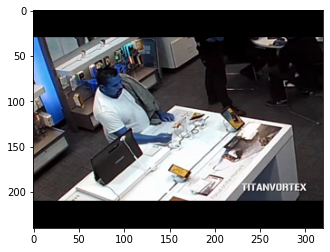

In [115]:
# test VideoPreprocessorFromFolder

def testTransform(frame, transform_param, frame_properties_input, frame_properties_output):
    return frame

def testTransform_graph(frame, transform_param, frame_properties_input, frame_properties_output):
    return [1]


path = 'video_test/input/Shoplifting054_x264.mp4'
vc = cv2.VideoCapture(path)
# Read first frame
ret, first_frame = vc.read()
fshape = first_frame.shape
fheight = fshape[0]
fwidth = fshape[1]
fps = int(vc.get(cv2.CAP_PROP_FPS))
plt.imshow(first_frame)
vc.release()

properties_in = {
        "fps":fps,
        "height":fheight,
        "width":fwidth,
        "channel":3,
        "nb_frames":100
    }
    
properties_out = {
        "fps":fps,
        "height":fheight,
        "width":fwidth,
        "channel":3,
        "nb_frames":100
    }

properties_out_graph = {
        "fps":fps
    }

vpff = VideoPreprocessorFromFolder(testTransform, None, properties_in, properties_out)

vpff.start('video_test/input', "video_test/output")

#gpff = GraphPreprocessorFromFolder(testTransform_graph, None, properties_in, properties_out)

#gpff.start('video_test/input', "video_test/output")

In [41]:
class OpticalFlowPreprocessor(VideoPreprocessorFromFolder):
    
    def __init__(self, frame_properties_input, frame_properties_output):
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        self.producer = CVProducer.generate_CVProducer(fourcc)
        self.consumer = CVConsumer.generate_CVConsumer()

        self.frame_properties_input  = frame_properties_input
        self.frame_properties_output = frame_properties_output
        self.frames_descriptor = {
            "type_of":"frames_descriptor",
            "address":{
                "datetime":datetime.now()
            },
            "frame_properties":frame_properties_output  
        }
          
    def transform(self, frame):
        
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = cv2.GaussianBlur(frame, (5, 5), 0)
        
        if self.old_frame is None:          
            delta_frame = np.zeros((self.frame_properties_output["height"],self.frame_properties_output["width"], 3), dtype = "uint8")
            
        else:  
            delta_frame=cv2.absdiff(self.old_frame, frame)
            delta_frame = cv2.cvtColor(delta_frame, cv2.COLOR_GRAY2BGR)
            
        self.old_frame = frame
        return delta_frame
        
    def produceCallback(self, frame):
        pass
        
        
    def callbackTransform(self, ret, frame):
        if frame is None:
            return
        if ret:
            frame_t = self.transform(frame)
            self.producer.publish("", frame_t, self.produceCallback)
            
    def start(self, path_in, path_out):
        self.producer.connect()
        self.consumer.connect()
        
        folder = os.listdir(path_in)
        
        for file in folder:
            
            self.old_frame = None

            topic_input = os.path.join(path_in, file)
            topic_output = path_out
            
            self.frames_descriptor["address"]["datetime"] = datetime.now()

            self.producer.init_message(topic_output, self.frames_descriptor)
            self.consumer.syncSubscribe(topic_input, self.callbackTransform)
            self.producer.flush()

In [48]:
class OpticalFlowFarnebackPreprocessor(VideoPreprocessorFromFolder):
    
    def __init__(self, frame_properties_input, frame_properties_output, pyr_scale = 0.5, levels = 5, winsize = 15, iterations = 5, poly_n = 3, poly_sigma = 1.1, flags = 0):
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        self.producer = CVProducer.generate_CVProducer(fourcc)
        self.consumer = CVConsumer.generate_CVConsumer()

        self.frame_properties_input  = frame_properties_input
        self.frame_properties_output = frame_properties_output
        self.frames_descriptor = {
            "type_of":"frames_descriptor",
            "address":{
                "datetime":datetime.now()
            },
            "frame_properties":frame_properties_output  
        }
        self.mask = np.zeros((self.frame_properties_output["height"], self.frame_properties_output["width"], 3), dtype = np.uint8)
        
        # Sets image saturation to maximum
        self.mask[:,:,1] = 255
        
        self.pyr_scale = pyr_scale
        self.levels = levels
        self.winsize = winsize 
        self.iterations = iterations
        self.poly_n = poly_n
        self.poly_sigma = poly_sigma
        self.flags = flags 
                 
    def transform(self, frame):
        
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        if self.old_frame is None:          
            dense_flow = frame
            
        else:  
            # Calculate dense optical flow by Farneback method
            # https://docs.opencv.org/3.0-beta/modules/video/doc/motion_analysis_and_object_tracking.html#calcopticalflowfarneback
            flow = cv2.calcOpticalFlowFarneback(self.old_frame, gray, None, 
                                                self.pyr_scale, 
                                                self.levels, 
                                                self.winsize, 
                                                self.iterations,
                                                self.poly_n , 
                                                self.poly_sigma, 
                                                self.flags)
            # Compute the magnitude and angle of the 2D vectors
            magnitude, angle = cv2.cartToPolar(flow[:,:,0], flow[:,:,1])
            # Set image hue according to the optical flow direction
            self.mask[:,:,0] = angle * 180 / np.pi / 2
            # Set image value according to the optical flow magnitude (normalized)
            self.mask[:,:,2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
            # Convert HSV to RGB (BGR) color representation
            rgb = cv2.cvtColor(self.mask, cv2.COLOR_HSV2BGR)
            # Open a new window and displays the output frame
            dense_flow = cv2.addWeighted(frame, 1,rgb, 2, 0)
            
        self.old_frame = gray
        
        return dense_flow
        
    def produceCallback(self, frame):
        pass
        
        
    def callbackTransform(self, ret, frame):
        if frame is None:
            return
        if ret:
            frame_t = self.transform(frame)
            self.producer.publish("", frame_t, self.produceCallback)
            
    def start(self, path_in, path_out):
        self.producer.connect()
        self.consumer.connect()
        
        folder = os.listdir(path_in)
        
        for file in folder:
            
            self.old_frame = None

            topic_input = os.path.join(path_in, file)
            topic_output = path_out
            
            self.frames_descriptor["address"]["datetime"] = datetime.now()

            self.producer.init_message(topic_output, self.frames_descriptor)
            self.consumer.syncSubscribe(topic_input, self.callbackTransform)
            self.producer.flush()

In [99]:
import openpifpaf

class PifpafPreprocessor(VideoPreprocessorFromFolder):
    
    def __init__(self, frame_properties_input, frame_properties_output, checkpoint):
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        self.predictor = openpifpaf.Predictor(checkpoint=checkpoint)
        self.producer = CVProducer.generate_CVProducer(fourcc)
        self.consumer = CVConsumer.generate_CVConsumer()

        self.frame_properties_input  = frame_properties_input
        self.frame_properties_output = frame_properties_output
        self.frames_descriptor = {
            "type_of":"frames_descriptor",
            "address":{
                "datetime":datetime.now()
            },
            "frame_properties":frame_properties_output  
        }
        
        self.radius = 5
        self.colors = [[0,100,255], [0,100,255], [0,255,255], [0,100,255], [0,255,255], [0,100,255],
                     [0,255,0], [255,200,100], [255,0,255], [0,255,0], [255,200,100], [255,0,255],
                     [0,0,255], [255,0,0], [200,200,0], [255,0,0], [200,200,0]]
        self.color = (255, 0, 0)
        self.thickness = -1
        self.squelet_point = [(15,13),(13,11),(16,14),(14,12),(11,12),(5,11),(6,12),
                              (5,6),(5,7),(6,8),(7,9),(8,10),(1,2),(0,1),(0,2),(1,3),(2,4),(3,5),(4,6)]
        self.blk_image = np.zeros((frame_properties_output["height"],frame_properties_output["width"], 3), dtype = "uint8")
          
    def extract_pose(self, predictions, frame):
        for pose in predictions:

            i = 0
            for point in pose.data:
                if (point.all() > 0):
                    im2 = cv2.circle(frame, point[0:2].astype(int), self.radius, self.color, self.thickness)
            for joint in self.squelet_point:
                if pose.data[joint[0]].all() > 0 and pose.data[joint[1]].all() > 0:
                    frame = cv2.line(frame, pose.data[joint[0]][0:2].astype(int), pose.data[joint[1]][0:2].astype(int), self.colors[i], 2)
                    i += 1
                    
        return frame
 
        
    def transform(self, frame):
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        predictions, gt_anns, image_meta = self.predictor.numpy_image(img)
        
        frame = self.blk_image.copy()
        
        self.extract_pose(predictions, frame)
        
        return frame
        
    def produceCallback(self, frame):
        if frame is None:
            #/!\ need to be changed
            print("error")
        
        
    def callbackTransform(self, ret, frame):
        if frame is None:
            return
        if ret:
            frame_t = self.transform(frame)
            self.producer.publish("", frame_t, self.produceCallback)

In [109]:
import openpifpaf
import PIL

class PifpafGraphPreprocessor(GraphPreprocessorFromFolder):
    
    def __init__(self, frame_properties_input, frame_properties_output, checkpoint):
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        self.predictor = openpifpaf.Predictor(checkpoint=checkpoint)
        self.producer = GraphProducer.generate_GraphProducer()
        self.consumer = CVConsumer.generate_CVConsumer()

        self.frame_properties_input  = frame_properties_input
        self.frame_properties_output = frame_properties_output
        self.frames_descriptor = {
            "type_of":"frames_descriptor",
            "address":{
                "datetime":datetime.now()
            },
            "frame_properties":frame_properties_output  
        }
        
        self.squelet_point = [(15,13),(13,11),(16,14),(14,12),(11,12),(5,11),(6,12),
                              (5,6),(5,7),(6,8),(7,9),(8,10),(1,2),(0,1),(0,2),(1,3),(2,4),(3,5),(4,6)]
        
    def scale_pose(self, max_val, val):
        return val / max_val
        
    def extract_pose(self, predictions):
        poses = []
        for pose in predictions:
            
            temp = pose.data
            temp[:,2] = np.ceil(temp[:,2])
            
            temp[:,0] = self.scale_pose(self.frame_properties_output["height"], temp[:,0])
            temp[:,1] = self.scale_pose(self.frame_properties_output["width"], temp[:,1])
            
            poses.append(temp.tolist())
 
        return poses
        
    def transform(self, frame):
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        predictions, gt_anns, image_meta = self.predictor.numpy_image(img)
        poses = self.extract_pose(predictions)
        
        return poses
        
    def produceCallback(self, frame):
        if frame is None:
            #/!\ need to be changed
            print("error")
        
        
    def callbackTransform(self, ret, frame):
        if frame is None:
            return
        if ret:
            poses = self.transform(frame)
            self.producer.publish("", poses, self.produceCallback)

# Test

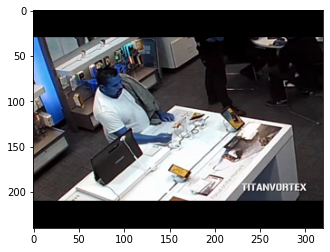

In [95]:
path = 'video_test/input/Shoplifting054_x264.mp4'
vc = cv2.VideoCapture(path)
# Read first frame
ret, first_frame = vc.read()
fshape = first_frame.shape
fheight = fshape[0]
fwidth = fshape[1]
fps = int(vc.get(cv2.CAP_PROP_FPS))
plt.imshow(first_frame)
vc.release()

properties_in = {
        "fps":fps,
        "height":fheight,
        "width":fwidth,
        "channel":3,
        "nb_frames":100
    }
    
properties_out= {
        "fps":fps,
        "height":fheight,
        "width":fwidth,
        "channel":3,
        "nb_frames":100
    }

vpff = OpticalFlowPreprocessor(properties_in, properties_out)

vpff.start('video_test/input', "video_test/output")

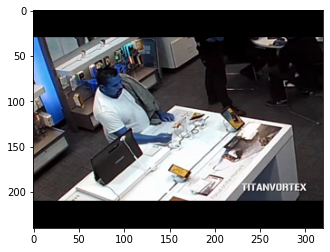

In [49]:
path = 'video_test/input/Shoplifting054_x264.mp4'
vc = cv2.VideoCapture(path)
# Read first frame
ret, first_frame = vc.read()
fshape = first_frame.shape
fheight = fshape[0]
fwidth = fshape[1]
fps = int(vc.get(cv2.CAP_PROP_FPS))
plt.imshow(first_frame)
vc.release()

properties_in = {
        "fps":fps,
        "height":fheight,
        "width":fwidth,
        "channel":3,
        "nb_frames":100
    }
    
properties_out= {
        "fps":fps,
        "height":fheight,
        "width":fwidth,
        "channel":3,
        "nb_frames":100
    }

vpff = OpticalFlowFarnebackPreprocessor(properties_in, properties_out)

vpff.start('video_test/input', "video_test/output")

KeyboardInterrupt: 

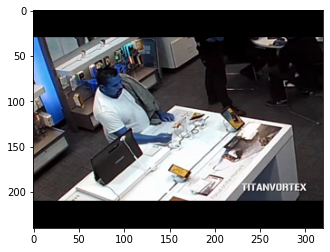

In [101]:
path = 'video_test/input/Shoplifting054_x264.mp4'
vc = cv2.VideoCapture(path)
# Read first frame
ret, first_frame = vc.read()
fshape = first_frame.shape
fheight = fshape[0]
fwidth = fshape[1]
fps = int(vc.get(cv2.CAP_PROP_FPS))
plt.imshow(first_frame)
vc.release()

properties_in = {
        "fps":fps,
        "height":fheight,
        "width":fwidth,
        "channel":3,
        "nb_frames":100
    }
    
properties_out= {
        "fps":fps,
        "height":fheight,
        "width":fwidth,
        "channel":3,
        "nb_frames":100
    }
checkpoint = "mobilenetv3small"
#checkpoint = "shufflenetv2k16"
vpff = PifpafPreprocessor(properties_in, properties_out, checkpoint)

vpff.start('video_test/input', "video_test/output")

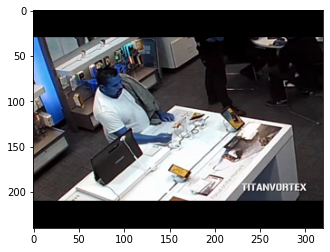

In [110]:
path = 'video_test/input/Shoplifting054_x264.mp4'
vc = cv2.VideoCapture(path)
# Read first frame
ret, first_frame = vc.read()
fshape = first_frame.shape
fheight = fshape[0]
fwidth = fshape[1]
fps = int(vc.get(cv2.CAP_PROP_FPS))
plt.imshow(first_frame)
vc.release()

properties_in = {
        "fps":fps,
        "height":fheight,
        "width":fwidth,
        "channel":3,
        "nb_frames":100
    }
    
properties_out= {
        "fps":fps,
        "height":fheight,
        "width":fwidth,
        "channel":3,
        "nb_frames":100
    }
checkpoint = "mobilenetv3small"
#checkpoint = "shufflenetv2k16"
vpff = PifpafGraphPreprocessor(properties_in, properties_out, checkpoint)

vpff.start('video_test/input', "video_test/output")

# Mixed Filter

In [55]:
class PifPafOpticalFlowPreprocessor(VideoPreprocessorFromFolder):
    
    def __init__(self, frame_properties_input, frame_properties_output, checkpoint):
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        self.producer = CVProducer.generate_CVProducer(fourcc)
        self.consumer = CVConsumer.generate_CVConsumer()
        self.predictor = openpifpaf.Predictor(checkpoint=checkpoint)
        self.frame_properties_input  = frame_properties_input
        self.frame_properties_output = frame_properties_output
        self.frames_descriptor = {
            "type_of":"frames_descriptor",
            "address":{
                "datetime":datetime.now()
            },
            "frame_properties":frame_properties_output  
        }
        self.radius = 3
        self.color = (255)
        self.thickness = -1
        self.squelet_point = [(15,13),(13,11),(16,14),(14,12),(11,12),(5,11),(6,12),
                              (5,6),(5,7),(6,8),(7,9),(8,10),(1,2),(0,1),(0,2),(1,3),(2,4),(3,5),(4,6)]
        self.blk_image = np.zeros((frame_properties_output["height"],frame_properties_output["width"], 1), dtype = "uint8")
        
    def extract_pose(self, predictions, frame):
        for pose in predictions:
            for point in pose.data:
                if (point.all() > 0):
                    im2 = cv2.circle(frame, point[0:2].astype(int), self.radius, self.color, self.thickness)
            for joint in self.squelet_point:
                if pose.data[joint[0]].all() > 0 and pose.data[joint[1]].all() > 0:
                    frame = cv2.line(frame, pose.data[joint[0]][0:2].astype(int), pose.data[joint[1]][0:2].astype(int), self.color, 2)
                    
        return frame
 
        
    def transform(self, frame):
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        predictions, gt_anns, image_meta = self.predictor.numpy_image(img)
        
        frame = self.blk_image.copy()
        
        self.extract_pose(predictions, frame)
        
        return frame
          
    def transform(self, frame):
        # for pifpaf model
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # for opticalflow
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gray = cv2.GaussianBlur(gray, (3, 3), 0)
        
        predictions, gt_anns, image_meta = self.predictor.numpy_image(img)
        frame = self.blk_image.copy()
        self.extract_pose(predictions, frame)
        
        if self.old_frame is None:          
            delta_frame = frame
        else:  
            delta_frame = cv2.add(cv2.absdiff(self.old_frame, gray), frame)
            #delta_frame = cv2.cvtColor(delta_frame, cv2.COLOR_GRAY2BGR)
             
        self.old_frame = gray
        
        return delta_frame
        
    def produceCallback(self, frame):
        pass
        
        
    def callbackTransform(self, ret, frame):
        if frame is None:
            return
        if ret:
            frame_t = self.transform(frame)
            self.producer.publish("", frame_t, self.produceCallback)
            
    def start(self, path_in, path_out):
        self.producer.connect()
        self.consumer.connect()
        
        folder = os.listdir(path_in)
        
        for file in folder:
            
            self.old_frame = None

            topic_input = os.path.join(path_in, file)
            topic_output = path_out
            
            self.frames_descriptor["address"]["datetime"] = datetime.now()

            self.producer.init_message(topic_output, self.frames_descriptor)
            self.consumer.syncSubscribe(topic_input, self.callbackTransform)
            self.producer.flush()

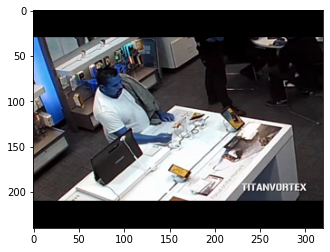

In [62]:
path = 'video_test/input/Shoplifting054_x264.mp4'
vc = cv2.VideoCapture(path)
# Read first frame
ret, first_frame = vc.read()
fshape = first_frame.shape
fheight = fshape[0]
fwidth = fshape[1]
fps = int(vc.get(cv2.CAP_PROP_FPS))
plt.imshow(first_frame)
vc.release()

properties_in = {
        "fps":fps,
        "height":fheight,
        "width":fwidth,
        "channel":3,
        "nb_frames":100
    }
    
properties_out= {
        "fps":fps,
        "height":fheight,
        "width":fwidth,
        "channel":0,
        "nb_frames":100
    }
checkpoint = "mobilenetv3small"
#checkpoint = "shufflenetv2k16"
vpff = PifPafOpticalFlowPreprocessor(properties_in, properties_out, checkpoint)

vpff.start('video_test/input', "video_test/output")